In [1]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib


In [2]:
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('figure', titlesize=25)

# Loading data

We will consider two datasets for binary classification task.
First dataset will be the **Banknote authentication dataset**. It concerns the task of detecting, whether the banknote is authentic or not, based on values such as skewness, curtosis, image entropy etc. The dataset is available [here](https://archive.ics.uci.edu/ml/datasets/banknote+authentication)
The second dataset is the **Titanic dataset**. The goal is to predict whether a person was likely to survive, based on values such as age, sex, ticket fare etc. The dataset is available [here](https://www.kaggle.com/competitions/titanic/overview)

In [3]:
bank_df = pd.read_csv('data/data_banknote_authentication.txt', header=None, na_values='?')
titanic_df = pd.read_csv('data/train.csv')
titanic_df = titanic_df.drop('PassengerId',axis=1)
bank_df.columns = ['variance', 'skewness', 'kurtosis', 'entropy', 'class']

In [4]:
categorical_columns = titanic_df.select_dtypes(include=['object']).columns
numerical_columns = titanic_df.select_dtypes(include=['int64', 'float64']).columns[1:]
bank_variables = bank_df.iloc[:,:-1].columns

# Missing values

Let us investigate the number of missing values in each dataset.

In [5]:
print(f"Number of NA values in Titanic dataset: {titanic_df.isna().any(axis=1).sum()}, all values: {len(titanic_df)}")

Number of NA values in Titanic dataset: 708, all values: 891


In [6]:
print(f"Number of NA values in Banknote dataset: {bank_df.isna().any(axis=1).sum()}, all values: {len(bank_df)}")

Number of NA values in Banknote dataset: 0, all values: 1372


As we can see, there are a lot of missing values in the **Titanic dataset**. Let us investigate further.

In [7]:
titanic_df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

As we can see the majority of values in the *Cabin* variable is missing - that is why we have decided to drop this variable alltogether. We will impute other missing values after splitting the dataset to train and test. We will use the median imputation for *Age*.

In [8]:
titanic_df = titanic_df.drop('Cabin', axis=1)

There are also two additional variables worth investigating: *Name* and *Ticket*.

In [9]:
len(titanic_df['Name'].unique())

891

In [10]:
len(titanic_df['Ticket'].unique())

681

As we can see, these variables have a majority of unique values, and as such are of little use to the task.

In [11]:
titanic_df = titanic_df.drop(['Name', 'Ticket'], axis=1)
categorical_columns = titanic_df.select_dtypes(include=['object']).columns

Let us also check for duplicates in both datasets.

In [12]:
print(f"Number of samples in Titanic dataset: {len(titanic_df)}, and without duplicates: "
      f"{len(titanic_df.drop_duplicates())}")

Number of samples in Titanic dataset: 891, and without duplicates: 780


In [13]:
print(f"Number of samples in Banknote dataset: {len(bank_df)}, and without duplicates: "
      f"{len(bank_df.drop_duplicates())}")

Number of samples in Banknote dataset: 1372, and without duplicates: 1348


There are some duplicates in the Banknote dataset, so let us drop them:

In [14]:
bank_df = bank_df.drop_duplicates()

# Data exploration

In [15]:
bank_df.head()

,variance,skewness,kurtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [16]:
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [17]:
bank_df.describe()

,variance,skewness,kurtosis,entropy,class
count,1348.000000,1348.000000,1348.000000,1348.000000,1348.000000
mean,0.445785,1.909039,1.413578,-1.168712,0.452522
std,2.862906,5.868600,4.328365,2.085877,0.497925
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.786650,-1.627000,-1.545600,-2.393100,0.000000
50%,0.518735,2.334150,0.605495,-0.578890,0.000000
75%,2.853250,6.796025,3.199800,0.403863,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [18]:
titanic_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Let us now plot the distributions of categorical and numerical columns.

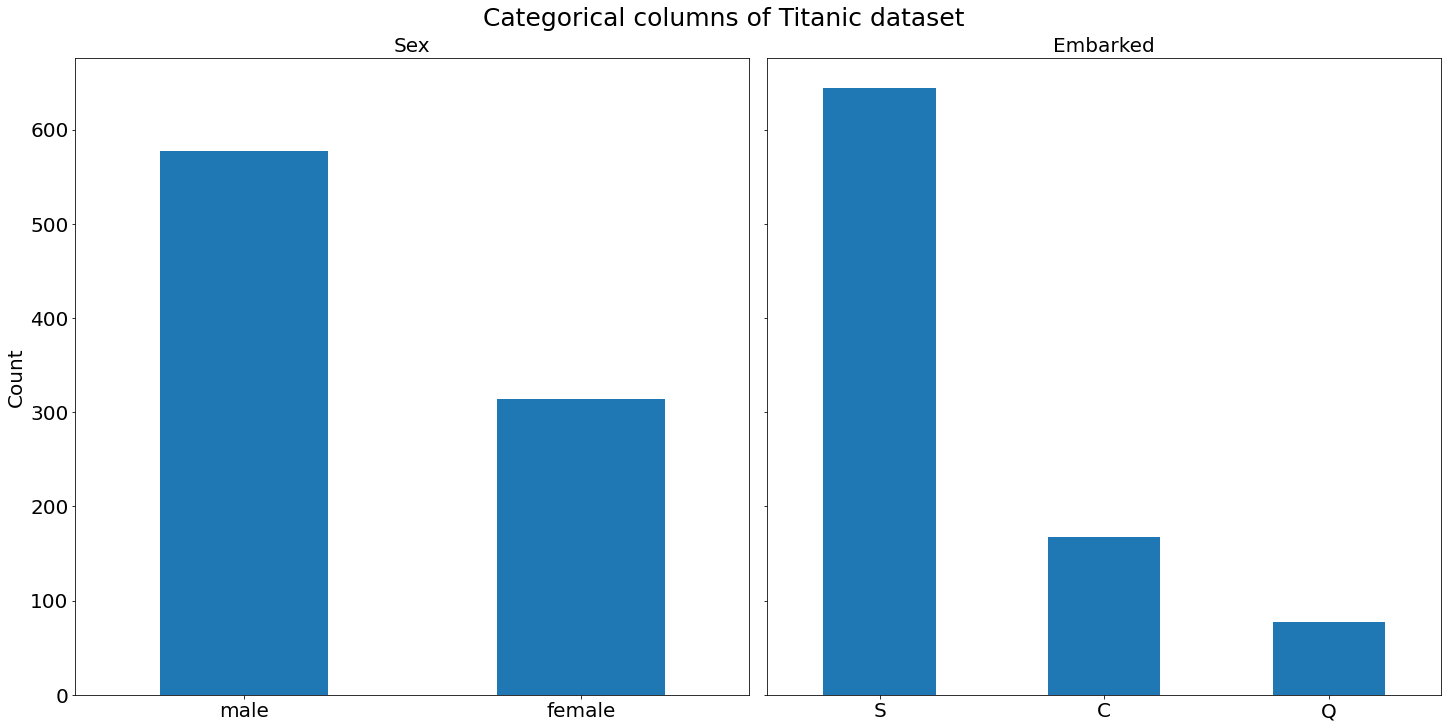

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), layout="constrained", sharey='all')
fig.suptitle("Categorical columns of Titanic dataset", fontsize=25)
for i, col in enumerate(list(categorical_columns)):
    titanic_df[col].value_counts().plot(kind='bar', ax = ax[i])
    ax[i].set_title(col)
    ax[i].set_ylabel("Count")
    ax[i].set_xlabel("")
    ax[i].tick_params(labelrotation=0)
plt.show()

As we can see, males dominate the *Gender* class, and S dominates the *Embarked* class.

Let us now check the numerical columns distribution:

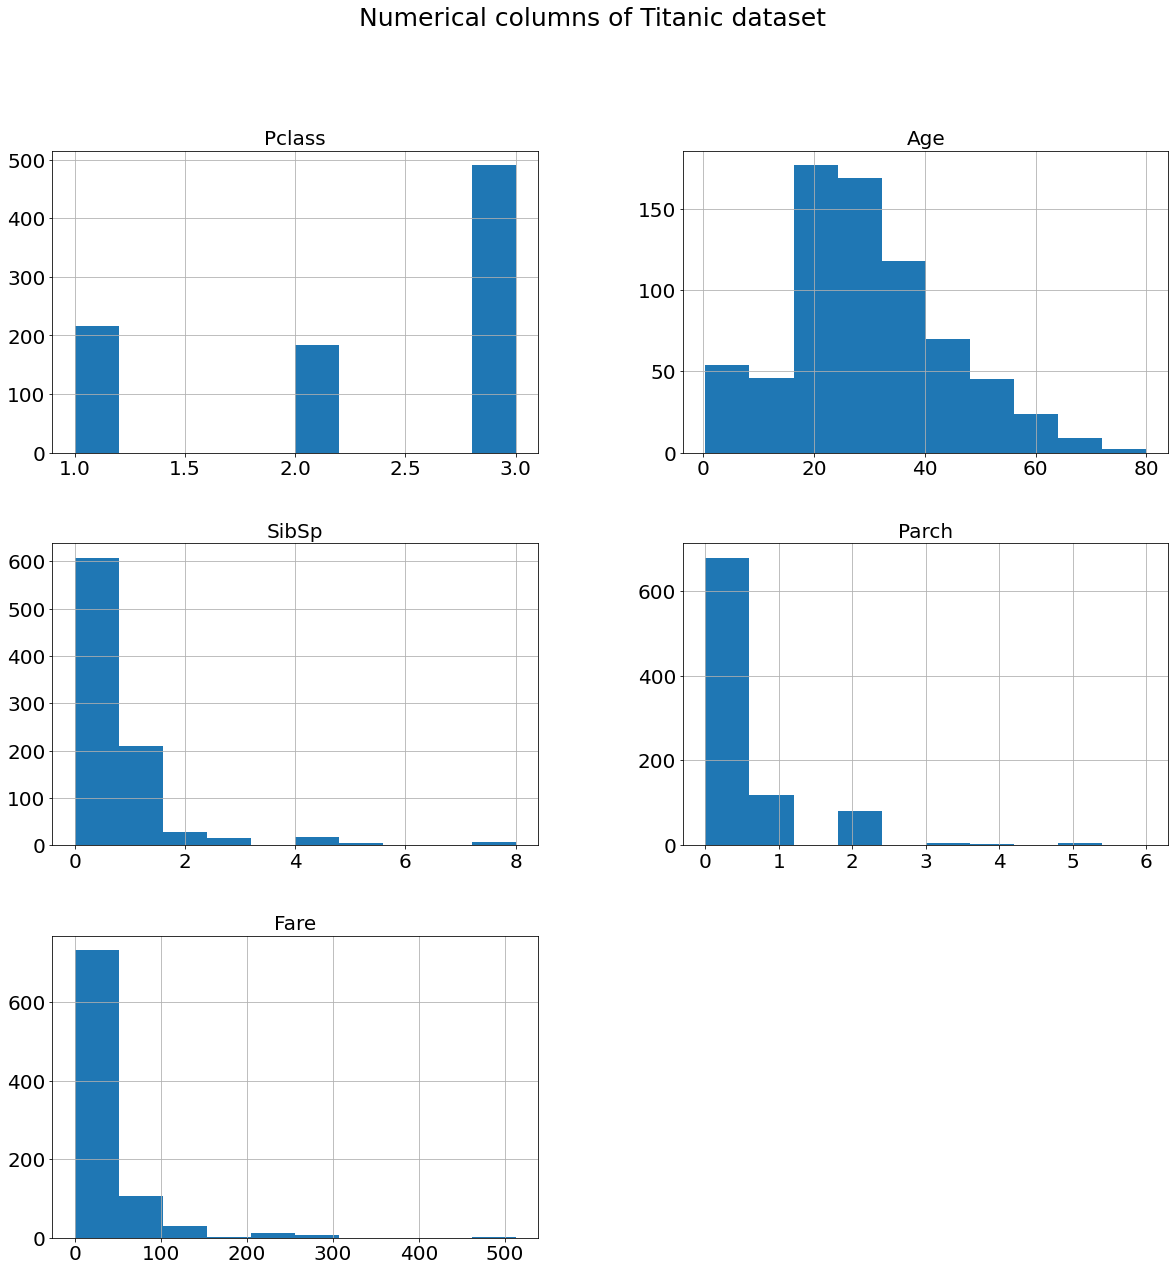

In [20]:
fig, ax = plt.subplots(3, 2, figsize=(20, 20))
fig.delaxes(ax[2,1])
fig.suptitle("Numerical columns of Titanic dataset", fontsize=25)
titanic_df[numerical_columns].hist(ax=ax.flatten()[:5])
plt.show()


As we can see, most of the values here are skewed.
What is more, *Pclass* has only 3 distinct values.

Lastly, lets check the distribution for the *survived* variable.

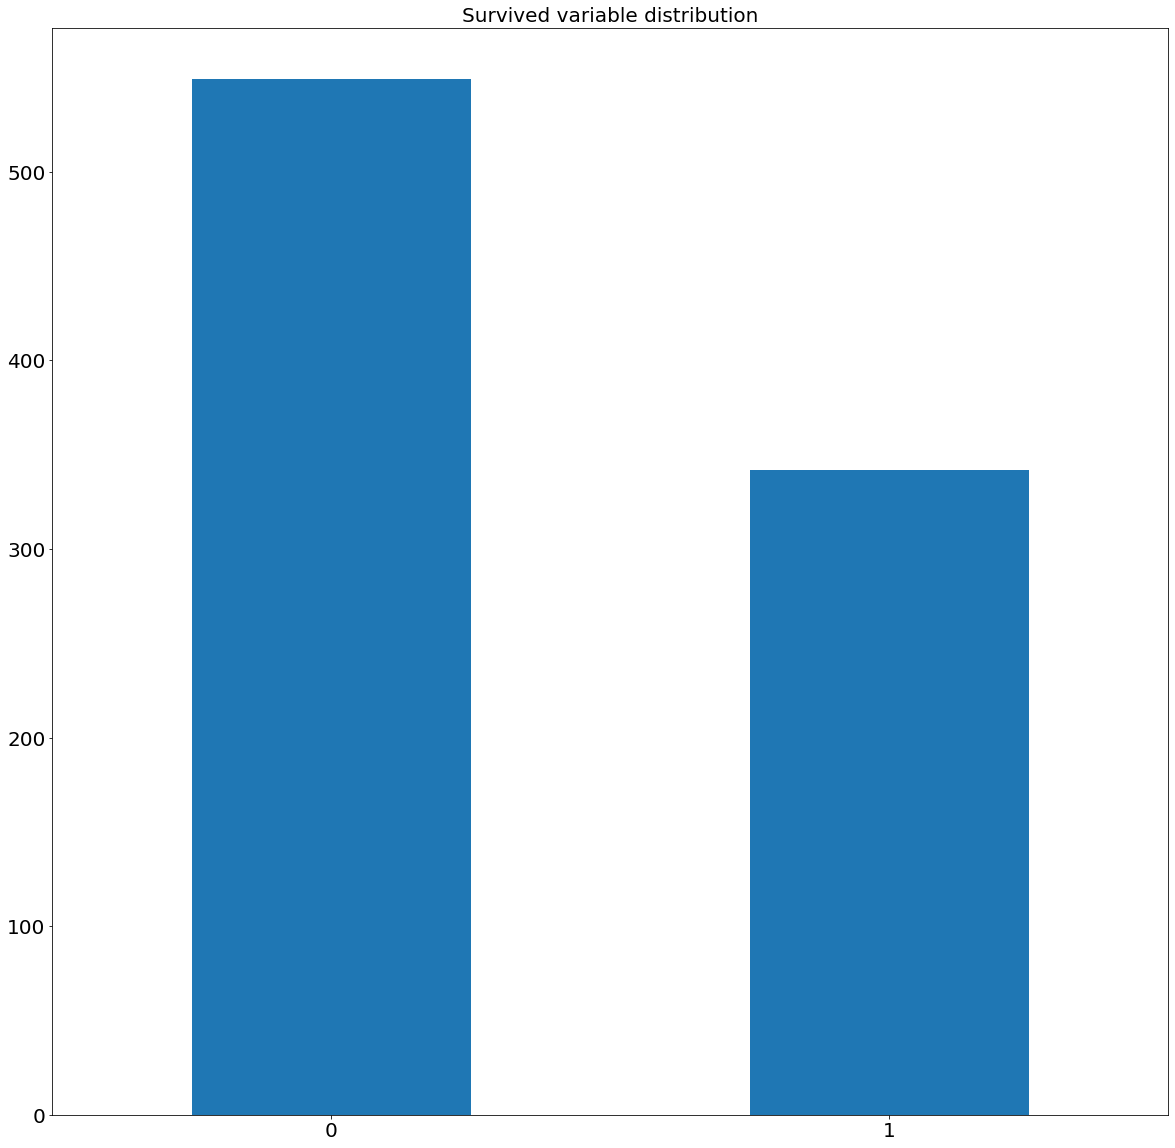

In [21]:
fig, ax = plt.subplots(figsize=(20,20))
titanic_df['Survived'].value_counts().plot(kind='bar', ax = ax)
plt.title("Survived variable distribution")
plt.xticks(rotation=0)
plt.show()

As we can see, the classes are sligtly unbalanced.

Let us also check the distributions of values from the **Banknote dataset**:

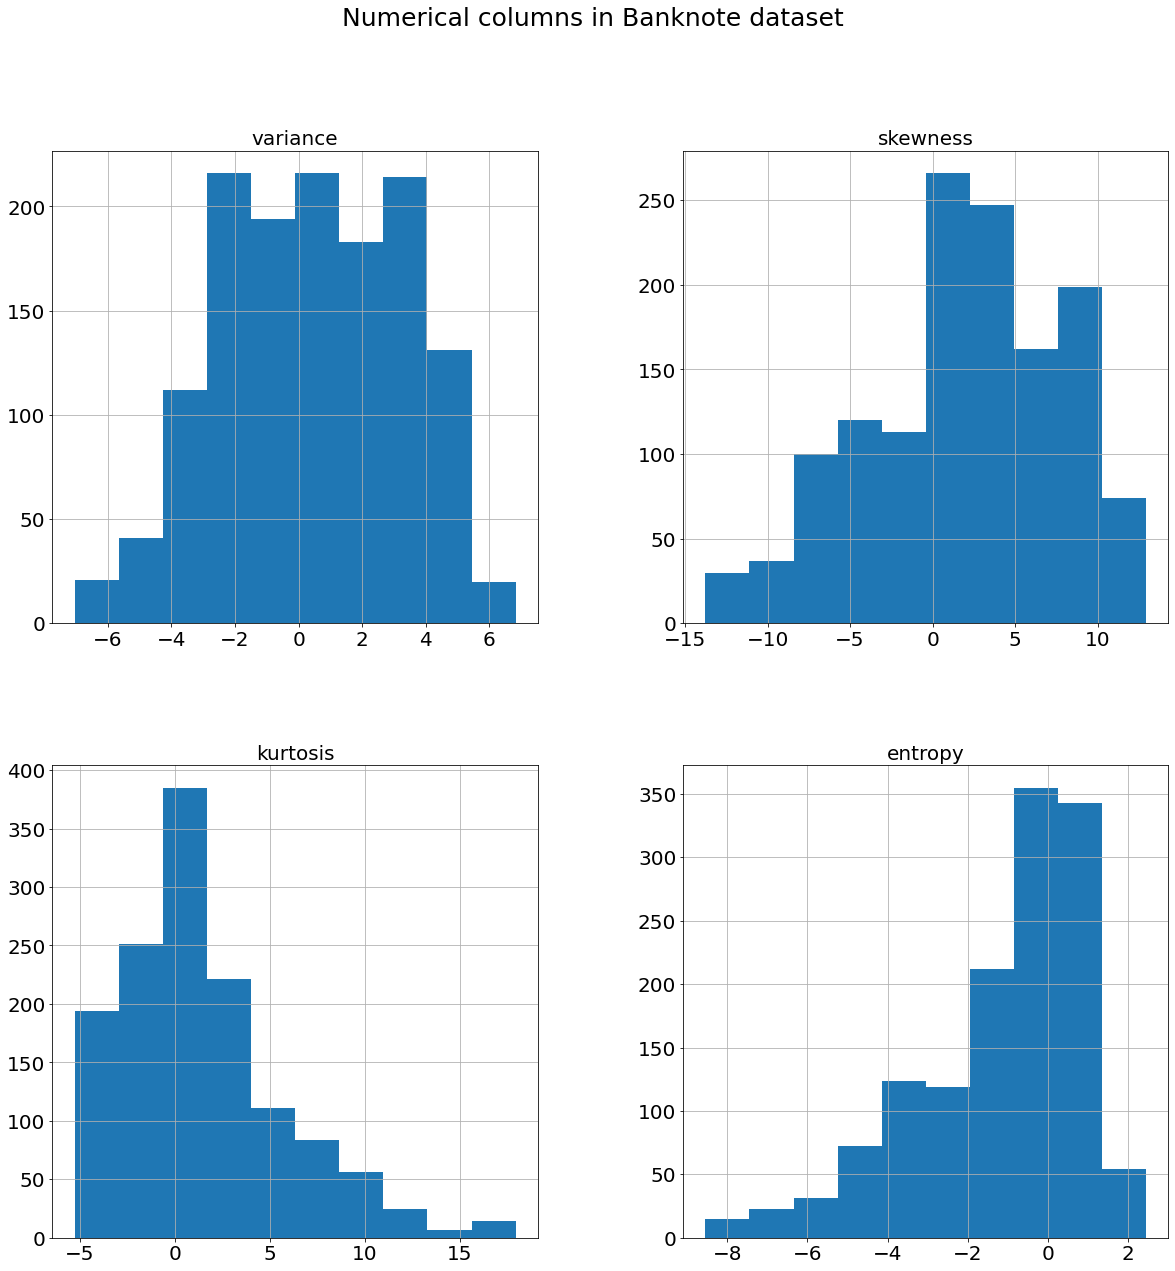

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
fig.suptitle("Numerical columns in Banknote dataset", fontsize=25)
bank_df[bank_variables].hist(ax=ax)
plt.show()

Here, values are slightly "better" distributed.
Lastly, let us look at the class variable in the **Banknote dataset**:

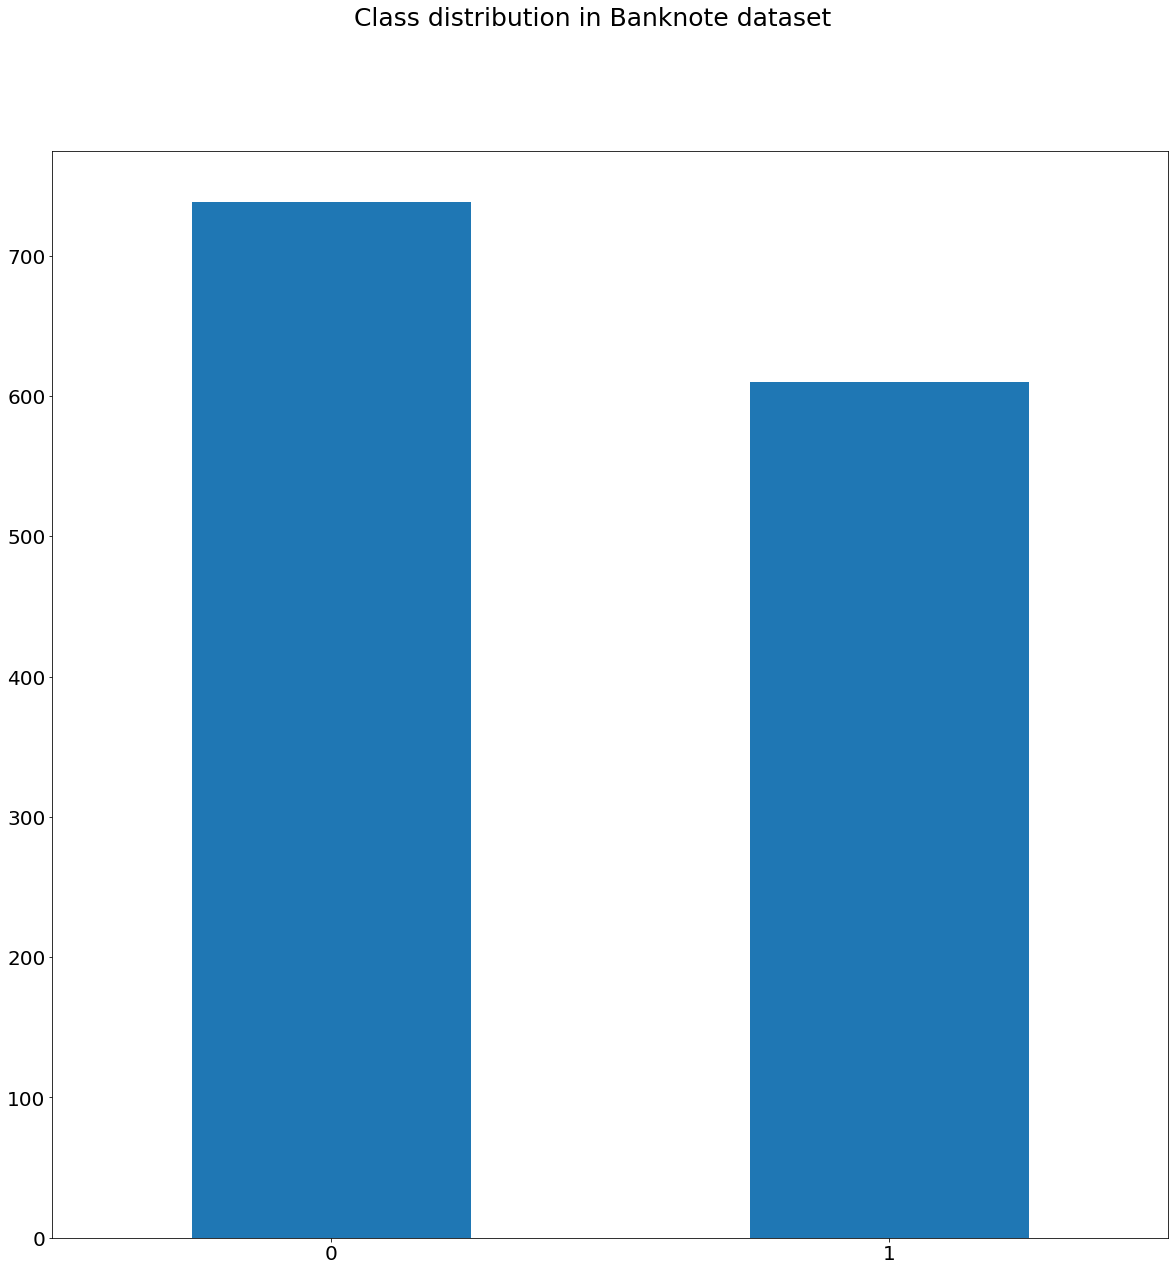

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
fig.suptitle("Class distribution in Banknote dataset", fontsize=25)
bank_df.iloc[:, -1].value_counts().plot(kind='bar', ax=ax)
plt.xticks(rotation=0)
plt.show()

They are better balanced than in the **Titanic dataset**.

# Encoding categorical variables

The **banknote dataset** does not have any categorical variables, so we will focus on the **Stroke dataset**.
For categorical variables, we will use one-hot encoding.

In [24]:
titanic_df = pd.get_dummies(titanic_df, drop_first=True)

In [25]:
for column in titanic_df.columns:
    if titanic_df[column].dtype == 'bool':
        titanic_df[column] = titanic_df[column].astype(np.int32)

Let us now also split datets into predictors and responses.

In [26]:
X_t, y_t = titanic_df.drop('Survived', axis=1), titanic_df['Survived']
X_bank, y_bank = bank_df.drop('class', axis=1), bank_df['class']

# Splitting data into train and test

Let us split both datasets: 80% for training and 20% for testing.

In [27]:
from sklearn.model_selection import train_test_split
titanic_df_X_train, titanic_df_X_test, titanic_df_y_train, titanic_df_y_test = train_test_split(X_t, y_t,
                                                                                            test_size=0.2, random_state=12)
bank_df_X_train, bank_df_X_test, bank_df_y_train, bank_df_y_test = train_test_split(X_bank, y_bank,
                                                                                    test_size=0.2,
                                                                                    random_state=12)

# Collinearity

Let us check the collinearity between the values of **Titanic dataset**.

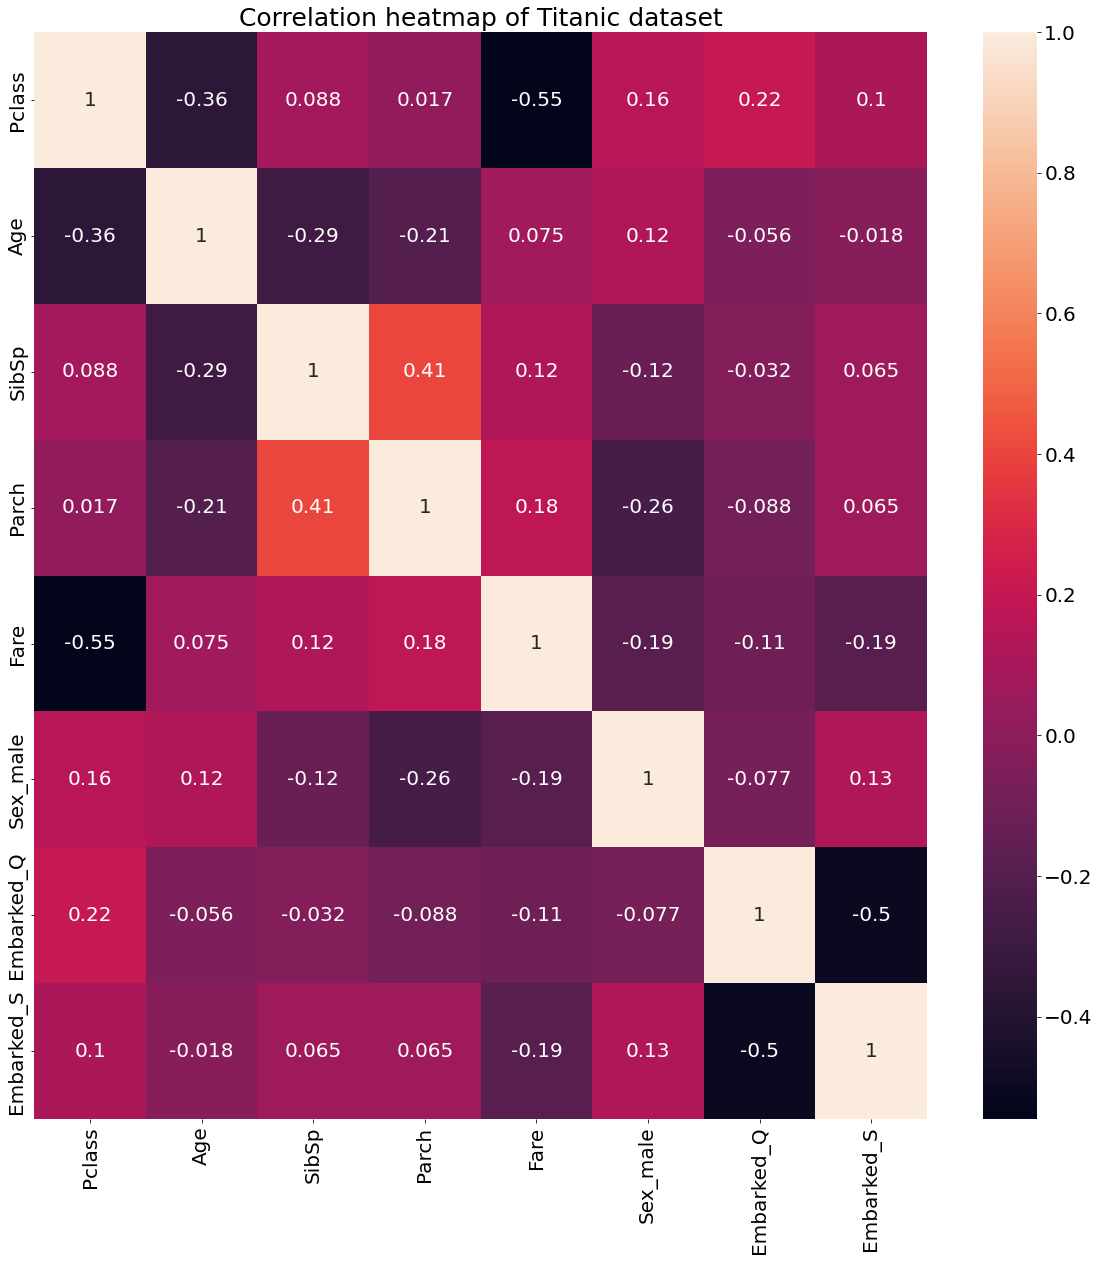

In [28]:
plt.figure(figsize=(20,20))
sns.heatmap(titanic_df_X_train.corr(), annot=True)
plt.title("Correlation heatmap of Titanic dataset", fontsize=25)
plt.show()

There seems to be small correlation between *Fare* and *Pclass*, but it's not very significant.

Let us also investigate the collinearity in the **Banknote dataset**:

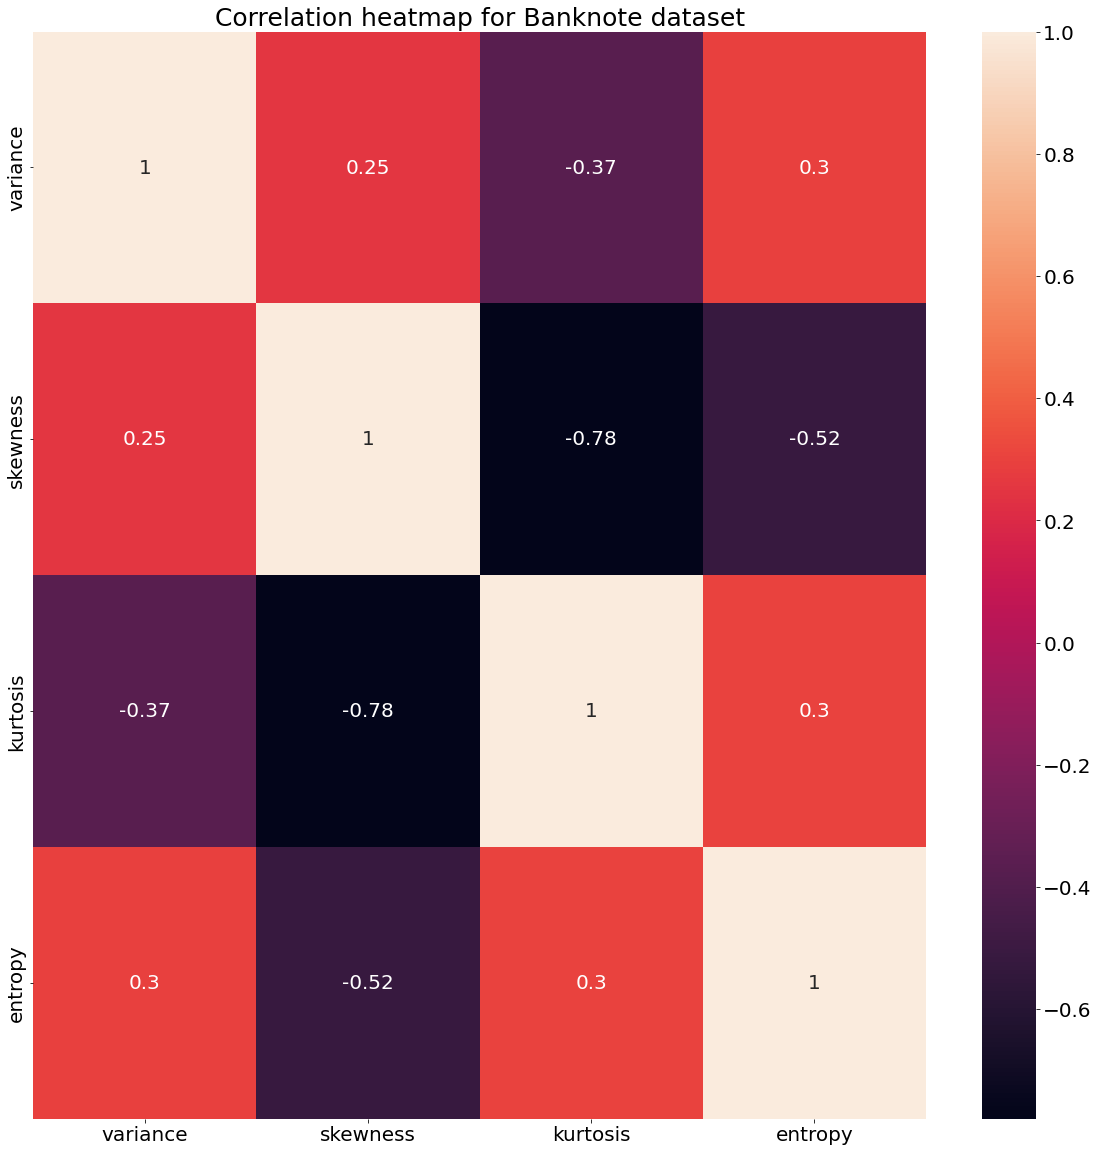

In [29]:
plt.figure(figsize=(20,20))
sns.heatmap(bank_df_X_train.corr(), annot=True)
plt.title("Correlation heatmap for Banknote dataset", fontsize=25)
plt.show()

Kurtosis and skewness seem to be somewhat correlated, but again, it is not significant.

# Loading models

In [30]:
# Implemented model
from IRLS import IRLS
# SKlearn models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR

We will consider multiple metrics: accuracy, balanced accuracy, f1-score, precision and recall scores.

In [31]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score
def compute_metrics(y, y_hat, verbose=False, pos_label=1):
    """
    :param y: true values
    :param y_hat: predicted values
    :param verbose: boolean, decides whether or not algorithm should print all the results
    :param pos_label: the positive label (for f1, precision and recall), default: 1
    :return: metrics: accuracy, balanced accuracy, f1 score, precision, recall
    """
    acc = accuracy_score(y, y_hat)
    b_acc = balanced_accuracy_score(y, y_hat)
    f1 = f1_score(y, y_hat, pos_label=pos_label)
    prec = precision_score(y, y_hat, pos_label=pos_label)
    recall = recall_score(y, y_hat, pos_label=pos_label)
    if verbose:
        print(f"Accuracy score: {acc}")
        print(f"Balanced accuracy score: {b_acc}")
        print(f"F1 score: {f1}")
        print(f"Precision score: {prec}")
        print(f"Recall score: {recall}")
    return acc, b_acc, f1, prec, recall



# Fitting and evaluating models

We will now fit and evaluate our models once, using the train-test split we have done earlier. However, to get some more consistent results, we will then use 10-fold cross validation and repeat it multiple (50) times.

In [32]:
numerical_columns = [0, 1, 2, 3, 4]
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
ct_titanic = Pipeline([
    ('imputer', ColumnTransformer(transformers=[('imputer', SimpleImputer(missing_values=np.nan, strategy='median'), [1])],
                                  remainder='passthrough')),
    ('scaler', ColumnTransformer(transformers=[('scaler', StandardScaler(), numerical_columns)],
                                 remainder='passthrough'))
                       ])
ct_bank = ColumnTransformer([('scaler', StandardScaler(), bank_variables)])

## Saving Data for R

Unfortunately, Python doesn't seem to have any ready implementations of IRLS, so we will use R to compute the results for this model. To do this, we will now save all the data to external files and later on read all the results from R.

In [33]:
pd.DataFrame(ct_titanic.fit_transform(titanic_df_X_train)).to_csv('titanic_df_X_train.csv', index=False)
pd.DataFrame(ct_titanic.fit_transform(titanic_df_X_test)).to_csv('titanic_df_X_test.csv', index=False)
titanic_df_y_train.to_csv('titanic_df_y_train.csv', index=False)
titanic_df_y_test.to_csv('titanic_df_y_test.csv', index=False)
pd.DataFrame(ct_bank.fit_transform(bank_df_X_train)).to_csv('bank_df_X_train.csv', index=False)
pd.DataFrame(ct_bank.fit_transform(bank_df_X_test)).to_csv('bank_df_X_test.csv', index=False)
bank_df_y_train.to_csv('bank_df_y_train.csv', index=False)
bank_df_y_test.to_csv('bank_df_y_test.csv', index=False)

Let us now read results from R.

In [34]:
irls_titanic = pd.read_csv('data/metrics_titanic.txt', delim_whitespace=True, header=None).to_numpy().flatten()
irls_bank = pd.read_csv('data/metrics_bank.txt', delim_whitespace=True, header=None).to_numpy().flatten()
metric_names = ['acc_', 'acc_b_', 'f1_', 'prec_', 'rec_']
metrics_titanic_irls = [pd.read_csv('data/' + name + 't.txt',
                                             delim_whitespace=True, header=None).to_numpy().flatten() for name in metric_names]
metrics_bank_irls = [pd.read_csv('data/' + name + 'b.txt',
                                             delim_whitespace=True, header=None).to_numpy().flatten() for name in metric_names]

## Python models

In [35]:
models = [IRLS(), LDA(), QDA(), KNN()]
model_names = ["IRLS - our implementation", "LDA", "QDA", "KNN"]

In [36]:
print("TITANIC DATASET")
for model, model_name in zip(models, model_names):
    pipe = Pipeline([('preprocess', ct_titanic), ('model', model)])
    pipe.fit(titanic_df_X_train, titanic_df_y_train)
    y_hat = pipe.predict(titanic_df_X_test)
    print(f"{model_name}")
    print("----------------------------")
    compute_metrics(titanic_df_y_test, y_hat, verbose=True)
    print("----------------------------")
print("IRLS - ready implementation")
print("----------------------------")
print(f"Accuracy score: {irls_titanic[0]}")
print(f"Balanced accuracy score: {irls_titanic[1]}")
print(f"F1 score: {irls_titanic[2]}")
print(f"Precision score: {irls_titanic[3]}")
print(f"Recall score: {irls_titanic[4]}")
print("----------------------------")

TITANIC DATASET
IRLS - our implementation
----------------------------
Accuracy score: 0.8044692737430168
Balanced accuracy score: 0.795759493670886
F1 score: 0.7651006711409395
Precision score: 0.8142857142857143
Recall score: 0.7215189873417721
----------------------------
LDA
----------------------------
Accuracy score: 0.770949720670391
Balanced accuracy score: 0.7604430379746836
F1 score: 0.7210884353741497
Precision score: 0.7794117647058824
Recall score: 0.6708860759493671
----------------------------
QDA
----------------------------
Accuracy score: 0.7932960893854749
Balanced accuracy score: 0.785759493670886
F1 score: 0.7549668874172185
Precision score: 0.7916666666666666
Recall score: 0.7215189873417721
----------------------------
KNN
----------------------------
Accuracy score: 0.7094972067039106
Balanced accuracy score: 0.6948101265822785
F1 score: 0.6338028169014085
Precision score: 0.7142857142857143
Recall score: 0.569620253164557
----------------------------
IRLS - rea

In [37]:
print("BANKNOTE DATASET")
for model, model_name in zip(models, model_names):
    pipe = Pipeline([('preprocess', ct_bank), ('model', model)])
    pipe.fit(bank_df_X_train, bank_df_y_train)
    y_hat = pipe.predict(bank_df_X_test)
    print(f"{model_name}")
    print("----------------------------")
    compute_metrics(bank_df_y_test, y_hat, verbose=True)
    print("----------------------------")
print("IRLS - ready implementation")
print("----------------------------")
print(f"Accuracy score: {irls_bank[0]}")
print(f"Balanced accuracy score: {irls_bank[1]}")
print(f"F1 score: {irls_bank[2]}")
print(f"Precision score: {irls_bank[3]}")
print(f"Recall score: {irls_bank[4]}")
print("----------------------------")

BANKNOTE DATASET
IRLS - our implementation
----------------------------
Accuracy score: 0.9925925925925926
Balanced accuracy score: 0.9924585218702866
F1 score: 0.9914529914529915
Precision score: 0.9914529914529915
Recall score: 0.9914529914529915
----------------------------
LDA
----------------------------
Accuracy score: 0.9851851851851852
Balanced accuracy score: 0.9869281045751634
F1 score: 0.9831932773109243
Precision score: 0.9669421487603306
Recall score: 1.0
----------------------------
QDA
----------------------------
Accuracy score: 0.9925925925925926
Balanced accuracy score: 0.9934640522875817
F1 score: 0.9915254237288135
Precision score: 0.9831932773109243
Recall score: 1.0
----------------------------
KNN
----------------------------
Accuracy score: 1.0
Balanced accuracy score: 1.0
F1 score: 1.0
Precision score: 1.0
Recall score: 1.0
----------------------------
IRLS - ready implementation
----------------------------
Accuracy score: 0.9888889
Balanced accuracy score: 0.

As we can see, the results are rather consistent among all models - oscilating around 0.75 for the **Titanic Dataset**, and around 1.00 for the **Banknote dataset**. KNN was the worst model in the **Titanic dataset**, while our implementation achieved some rather satisfying results - on the other hand, it performed sligtly worse than the others on the **Banknote dataset**.

In [38]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

In [39]:
# defining scores for cross validation
scoring = ['accuracy', 'balanced_accuracy', 'f1', 'recall', 'precision']
N = 50 # experiment repeats

In [40]:
# Creating dictonaries for scores
metric_dicts_titanic = [{model_name:np.array([]) for model_name in model_names} for i in range(len(scoring))]
metric_dicts_bank = [{model_name:np.array([]) for model_name in model_names} for i in range(len(scoring))]

In [41]:
for i in range(N):
    for model, model_name in zip(models, model_names):
        pipe = Pipeline([('preprocess', ct_titanic), ('model', model)])
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=12)
        score = cross_validate(pipe, X_t, y_t, scoring=scoring, cv=cv)
        for metric_name, metric_dict in zip(scoring, metric_dicts_titanic):
            metric_dict[model_name] = np.concatenate([metric_dict[model_name], score['test_' + metric_name]])
for i in range(len(scoring)):
    metric_dicts_titanic[i]['IRLS - ready implementation'] = metrics_titanic_irls[i]

In [42]:
for i in range(N):
    for model, model_name in zip(models, model_names):
        pipe = Pipeline([('preprocess', ct_bank), ('model', model)])
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=12)
        score = cross_validate(pipe, X_bank, y_bank, scoring=scoring, cv=cv)
        for metric_name, metric_dict in zip(scoring, metric_dicts_bank):
            metric_dict[model_name] = np.concatenate([metric_dict[model_name], score['test_' + metric_name]])
for i in range(len(scoring)):
    metric_dicts_bank[i]['IRLS - ready implementation'] = metrics_bank_irls[i]

Let us plot the results as boxplots.

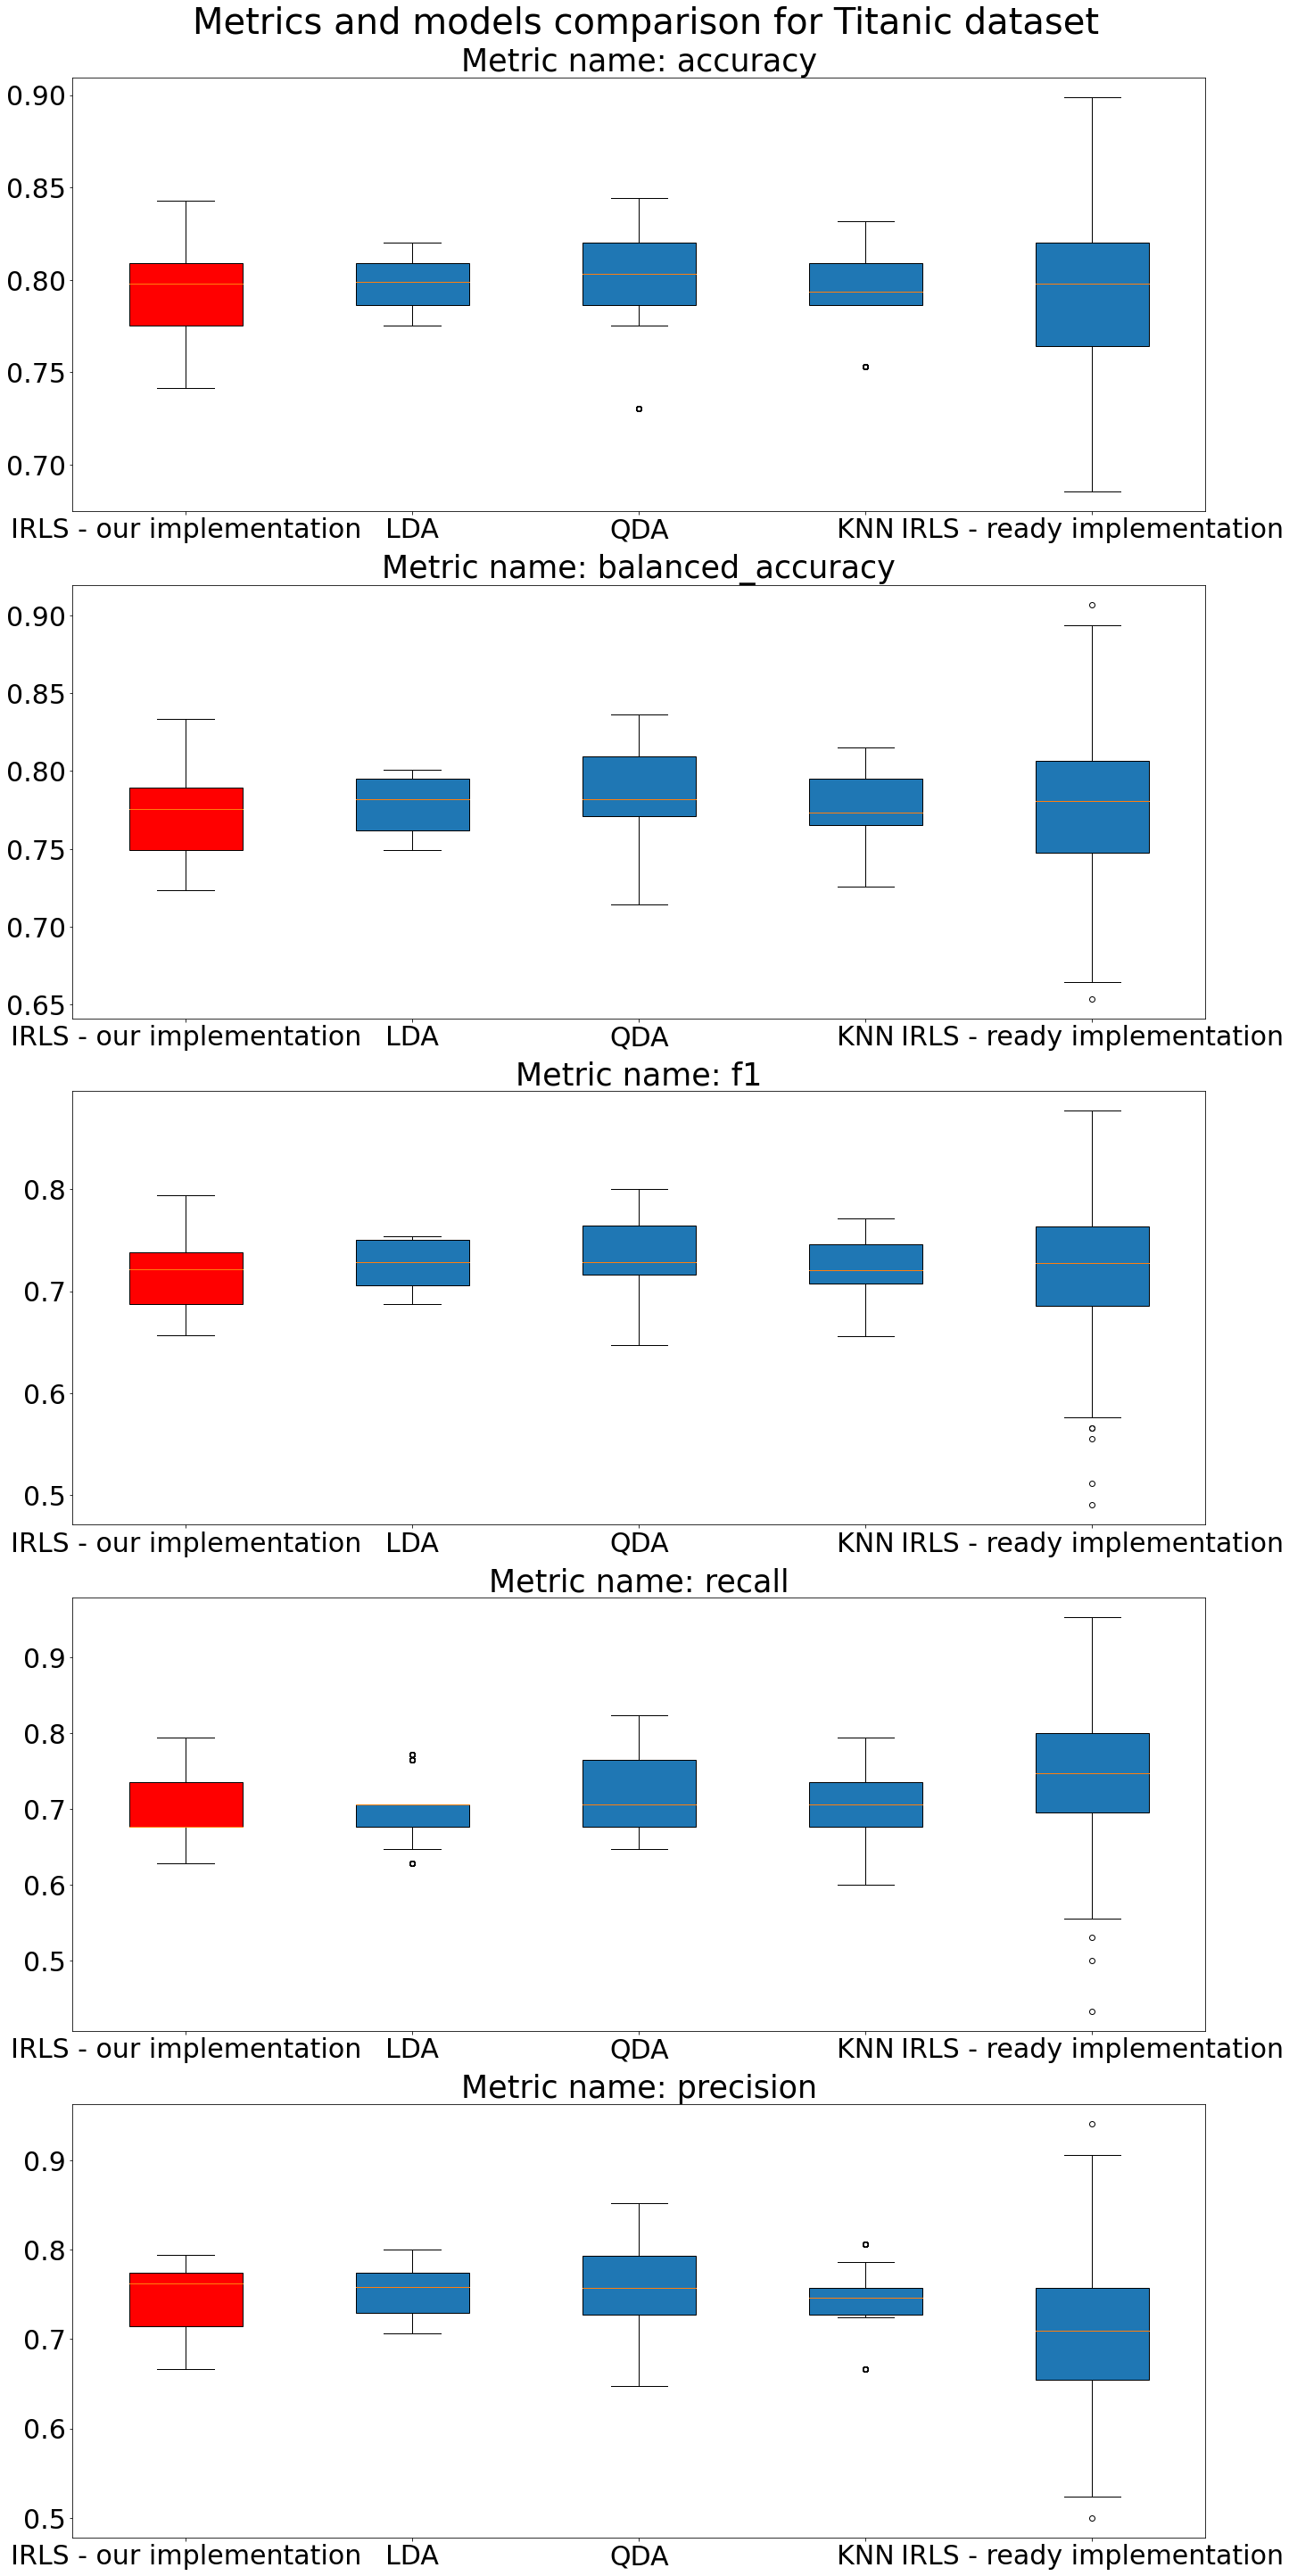

In [49]:
fig, ax = plt.subplots(5,1,figsize=(20,40), layout="constrained")
fig.suptitle("Metrics and models comparison for Titanic dataset", fontsize=40)
matplotlib.rc('xtick', labelsize=30)
matplotlib.rc('ytick', labelsize=30)
for i, (dict, metric_name) in enumerate(zip(metric_dicts_titanic, scoring)):
    labels, data = dict.keys(), dict.values()
    bp = ax[i].boxplot(data, patch_artist=True)
    bp['boxes'][0].set_facecolor('red')
    ax[i].set_xticks(range(1, len(labels) + 1), labels)
    ax[i].set_title(f"Metric name: {metric_name}", fontsize=35)
plt.show()

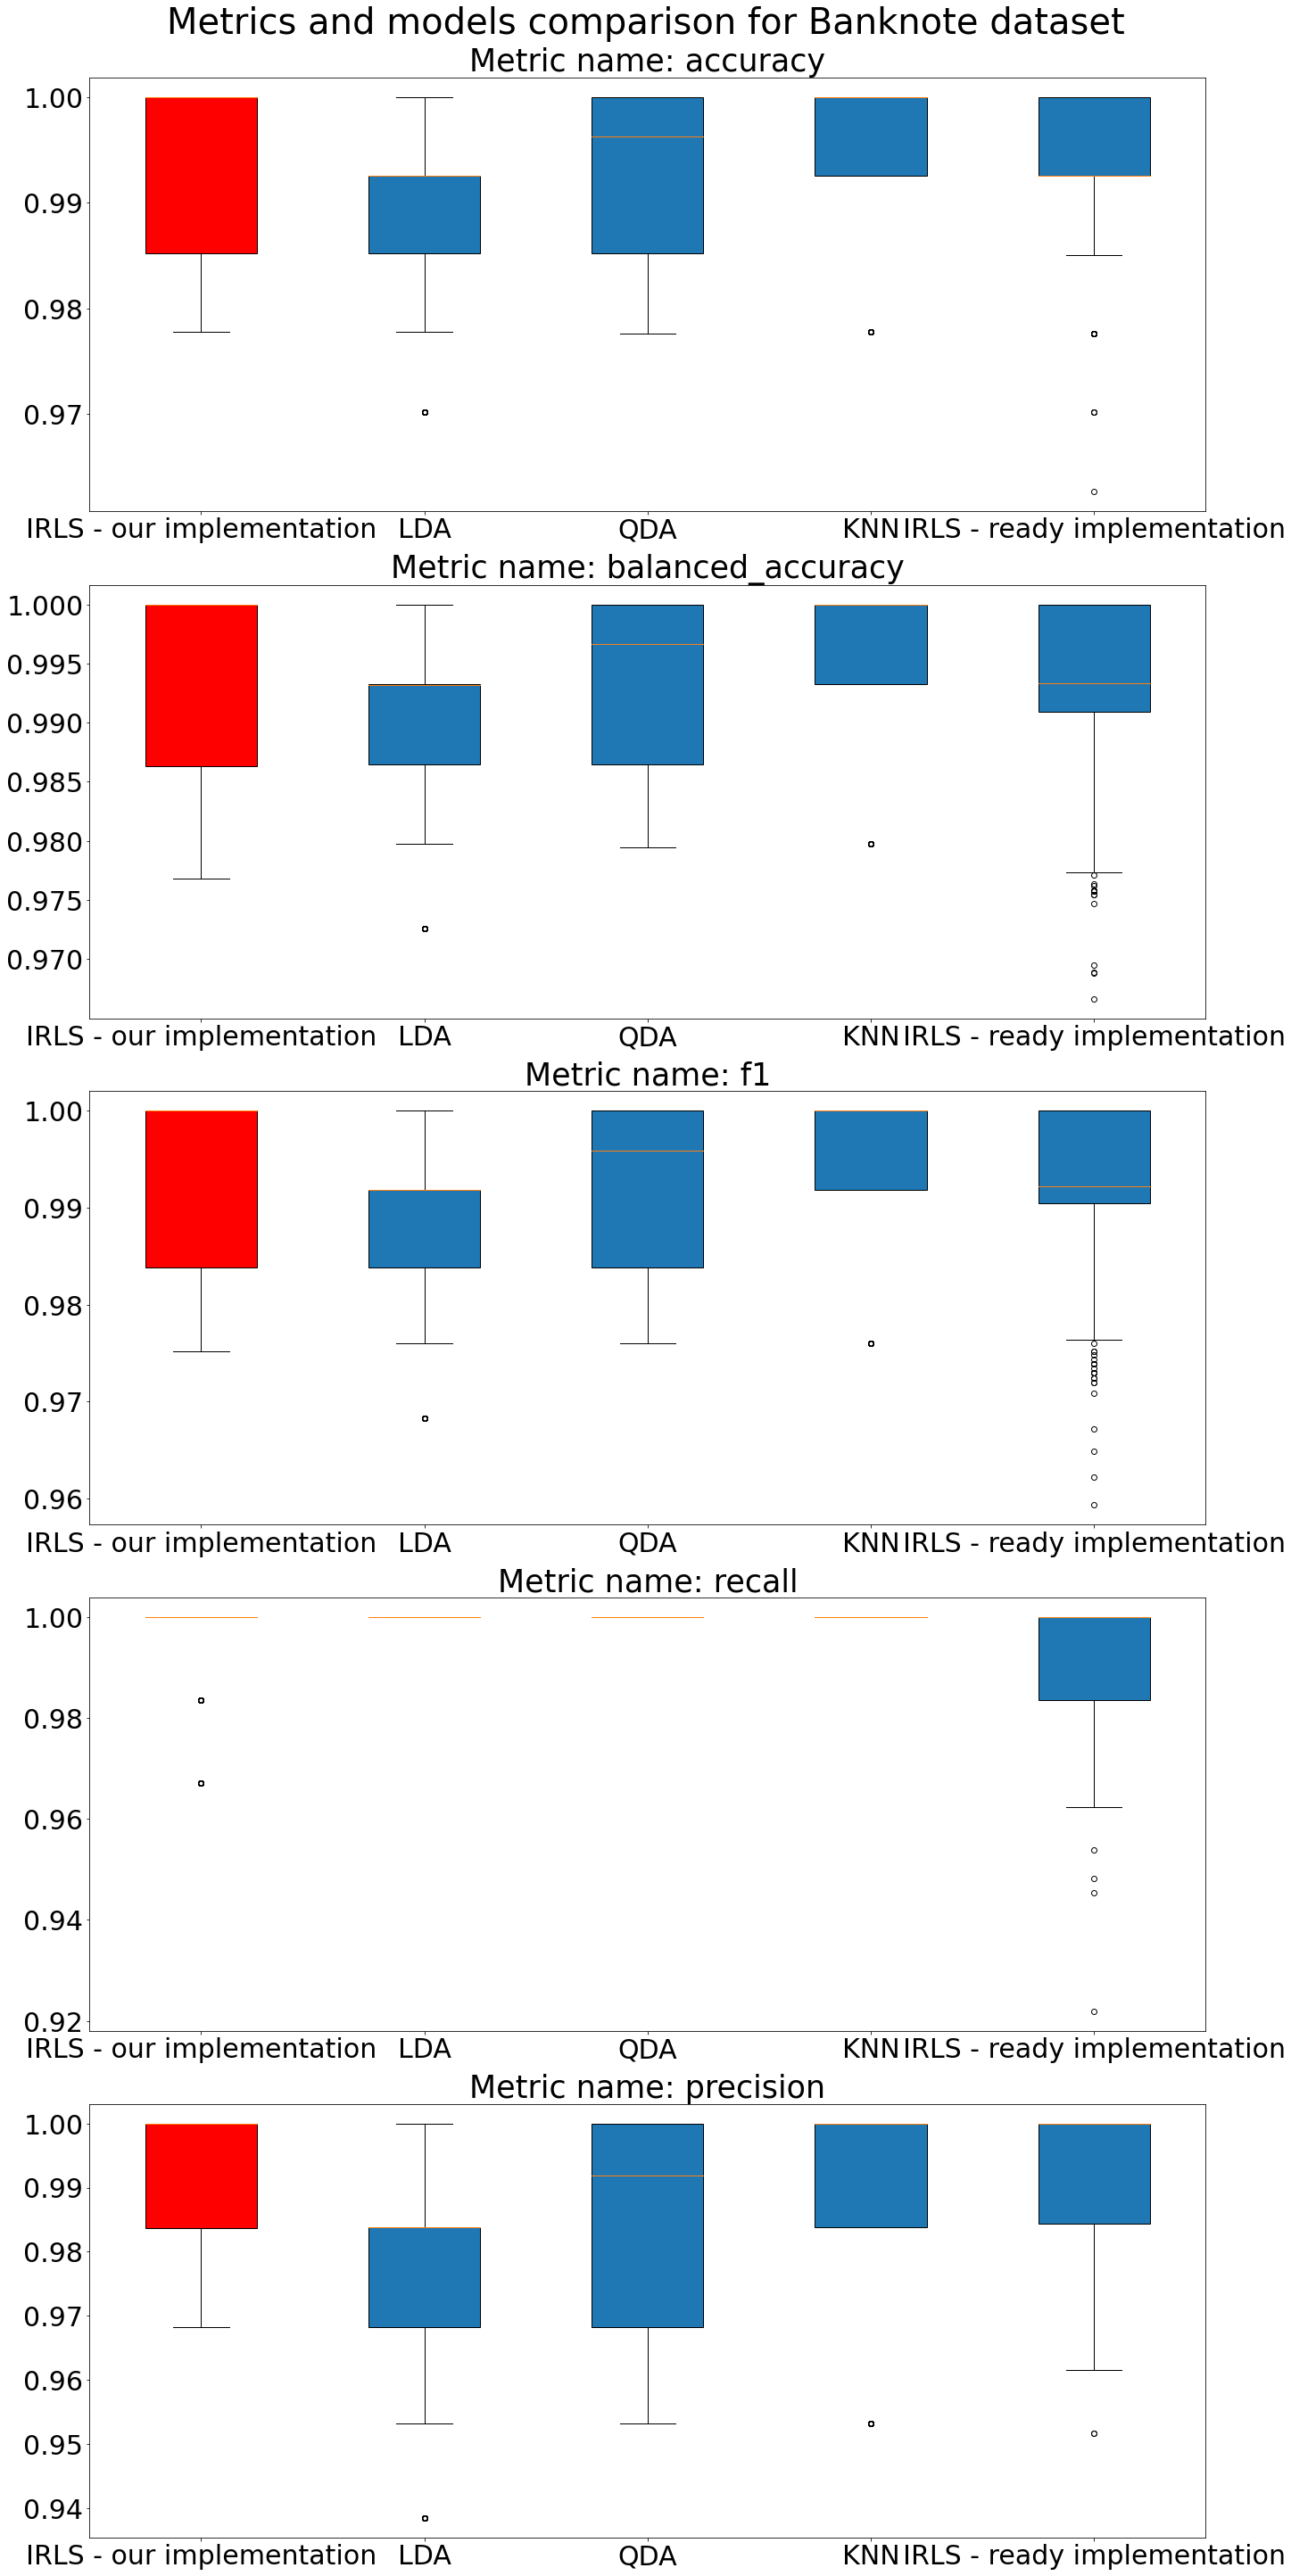

In [50]:
fig, ax = plt.subplots(5,1,figsize=(20,40), layout="constrained")
fig.suptitle("Metrics and models comparison for Banknote dataset", fontsize=40)
matplotlib.rc('xtick', labelsize=30)
matplotlib.rc('ytick', labelsize=30)
for i, (dict, metric_name) in enumerate(zip(metric_dicts_bank, scoring)):
    labels, data = dict.keys(), dict.values()
    bp = ax[i].boxplot(data, patch_artist=True)
    bp['boxes'][0].set_facecolor('red')
    ax[i].set_xticks(range(1, len(labels) + 1), labels)
    ax[i].set_title(f"Metric name: {metric_name}", fontsize=35)
plt.show()

As we can see, in general our implementation is comparable to different, readily-implemented models, and in some cases even surpasses them.

# Model with and without interactions

In [49]:
interactions_titanic = [None, [[1,4]], [[1,1]], [[0,3]], [[1,1], [4,4], [0,2]]]
interactions_bank = [None, [[0,1]], [[2,2]], [[0,3]], [[0,0], [1,1], [2,2]]]
interactions_names_titanic = ["normal", "Age-Fare", "Age-Age", "Fare-Fare", "Age-Age,F-F,Pclass-SibSp"]
interactions_names_bank = ["normal", 'var-sk', 'kur-kur', 'var-entr', 'var-var,sk-sk,kur-kur']
N = 50

In [50]:
inter_dict_titanic = [{in_name:np.array([]) for in_name in interactions_names_titanic} for i in range(len(scoring))]
inter_dict_bank =[{in_name:np.array([]) for in_name in interactions_names_bank} for i in range(len(scoring))]

In [51]:
for i in range(N):
    for interaction, in_name in zip(interactions_titanic, interactions_names_titanic):
        pipe = Pipeline([('preprocess', ct_titanic), ('model', IRLS(interactions=interaction))])
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=12)
        score = cross_validate(pipe, X_t, y_t, scoring=scoring, cv=cv)
        for metric_name, metric_dict in zip(scoring, inter_dict_titanic):
            metric_dict[in_name] = np.concatenate([metric_dict[in_name], score['test_' + metric_name]])

In [53]:
for i in range(N):
    for interaction, in_name in zip(interactions_bank, interactions_names_bank):
        pipe = Pipeline([('preprocess', ct_bank), ('model', IRLS(interactions=interaction))])
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=12)
        score = cross_validate(pipe, X_bank, y_bank, scoring=scoring, cv=cv)
        for metric_name, metric_dict in zip(scoring, inter_dict_bank):
            metric_dict[in_name] = np.concatenate([metric_dict[in_name], score['test_' + metric_name]])

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

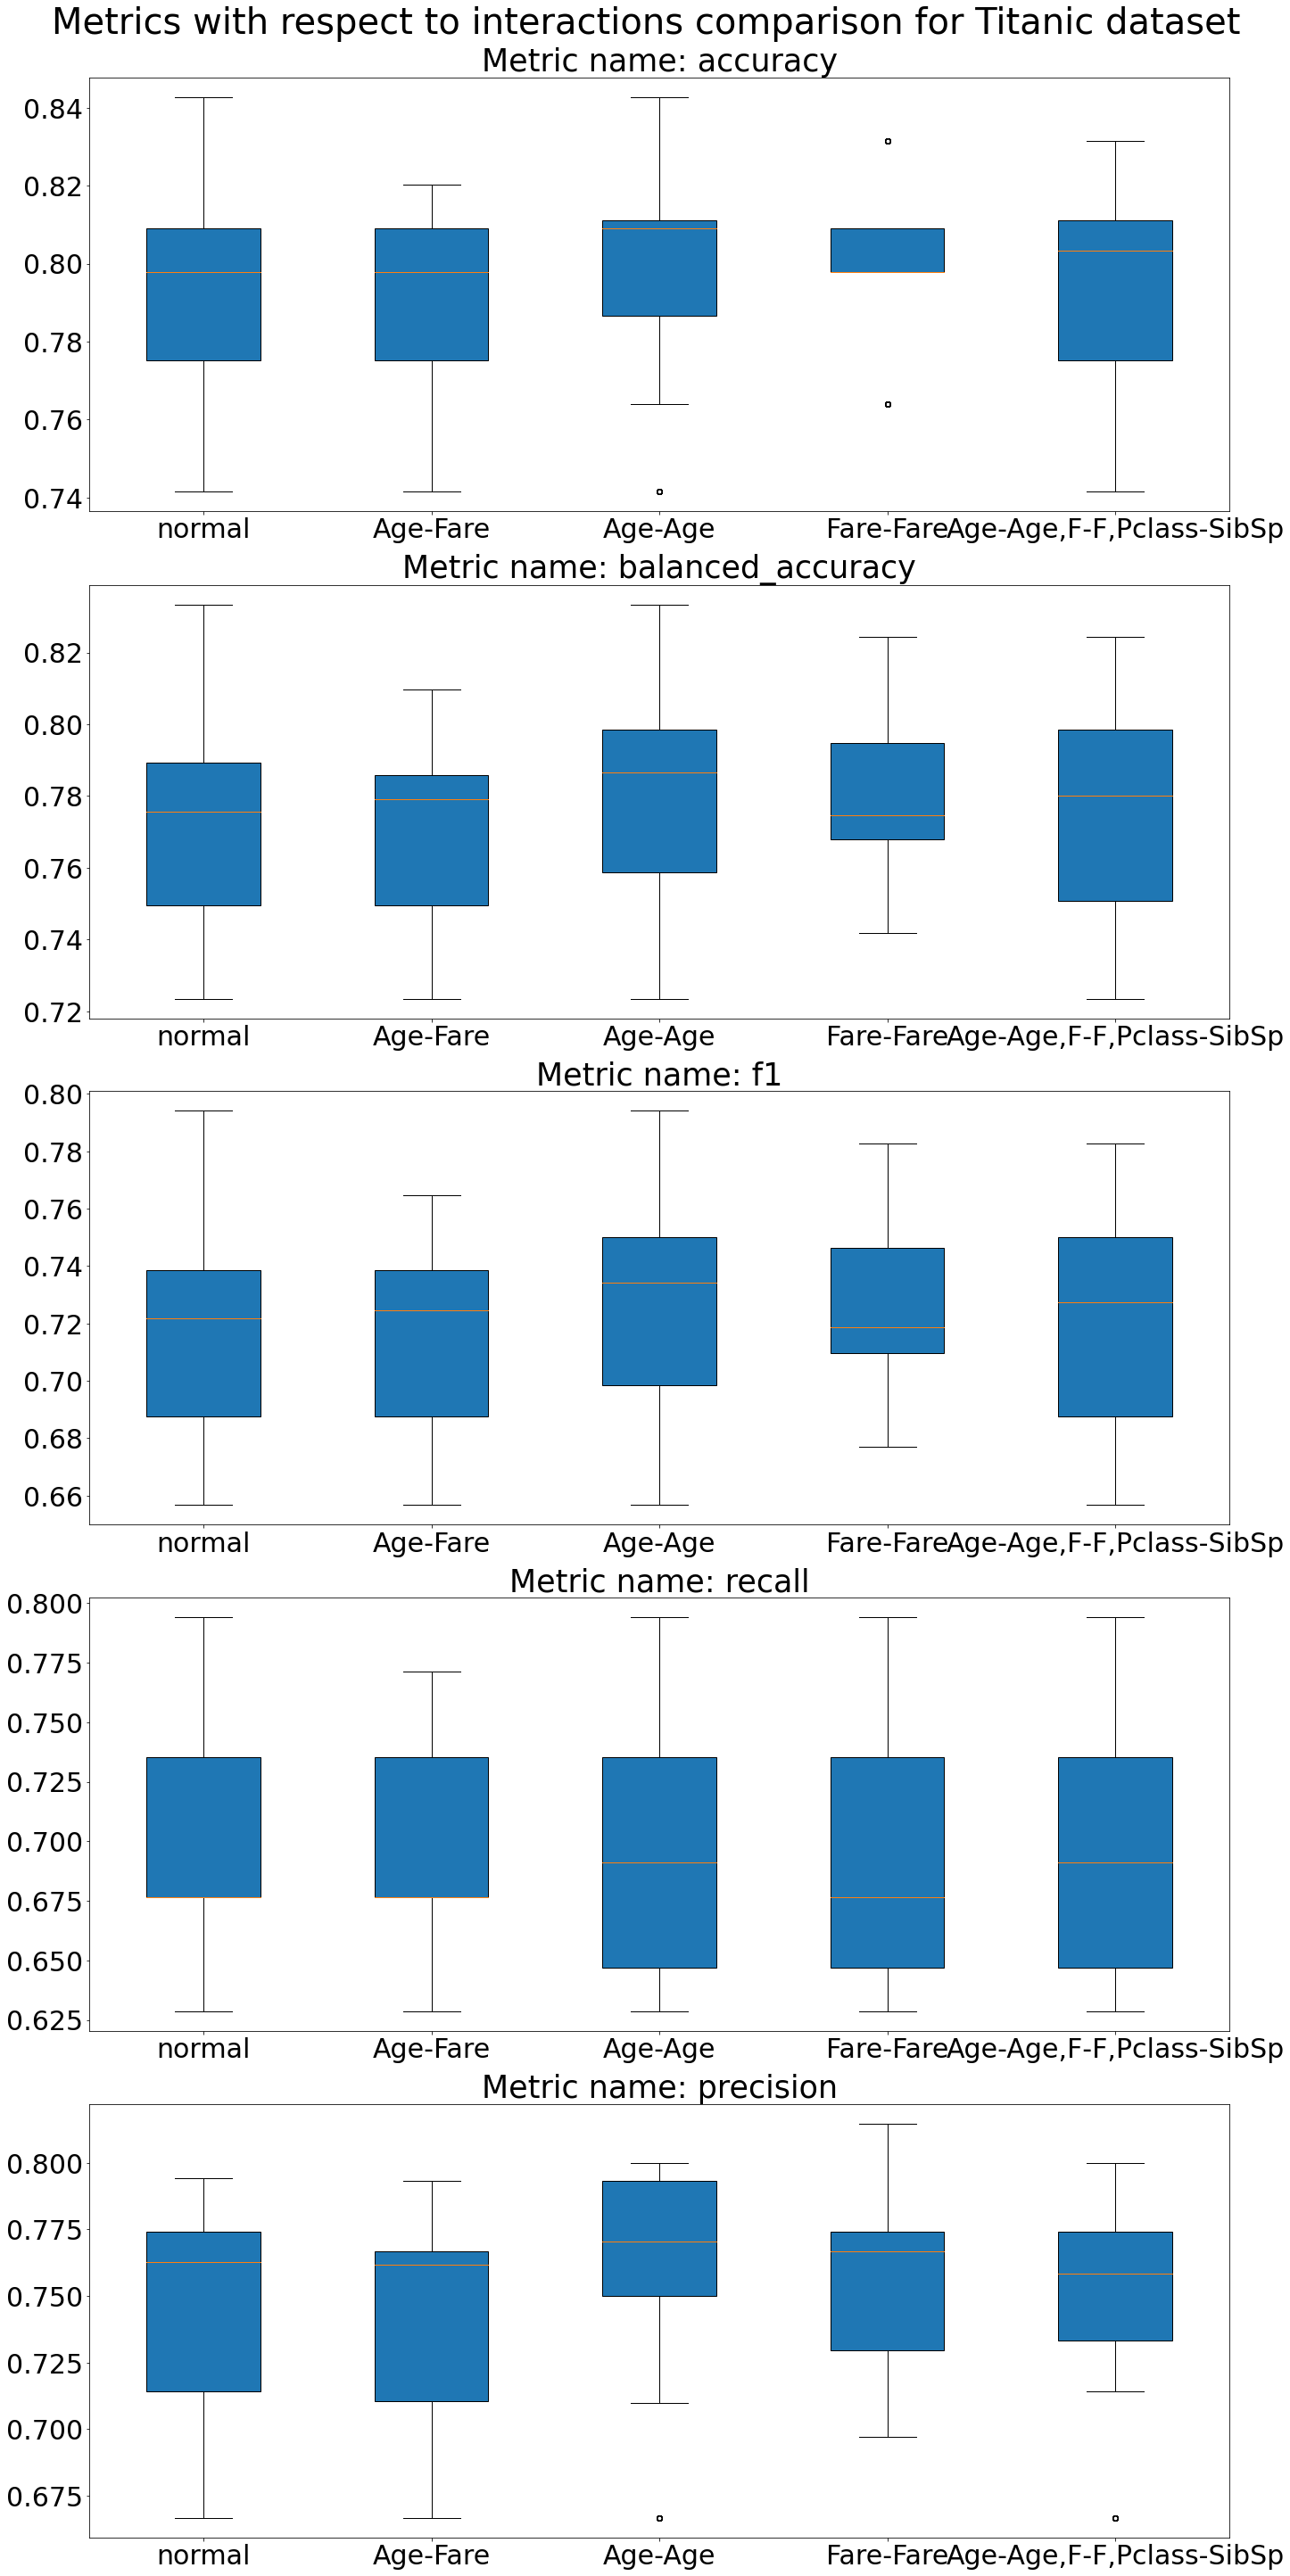

In [52]:
fig, ax = plt.subplots(5,1,figsize=(20,40), layout="constrained")
fig.suptitle("Metrics with respect to interactions comparison for Titanic dataset", fontsize=40)
matplotlib.rc('xtick', labelsize=30)
matplotlib.rc('ytick', labelsize=30)
for i, (dictionary, metric_name) in enumerate(zip(inter_dict_titanic, scoring)):
    labels, data = dictionary.keys(), dictionary.values()
    ax[i].boxplot(data, patch_artist=True)
    ax[i].set_xticks(range(1, len(labels) + 1), labels)
    ax[i].set_title(f"Metric name: {metric_name}", fontsize=35)
plt.show()

As we can see, some interactions actually stabilized the results for our model on the **Titanic dataset**, and interactions such as 1x1 (which means *Age* squared).

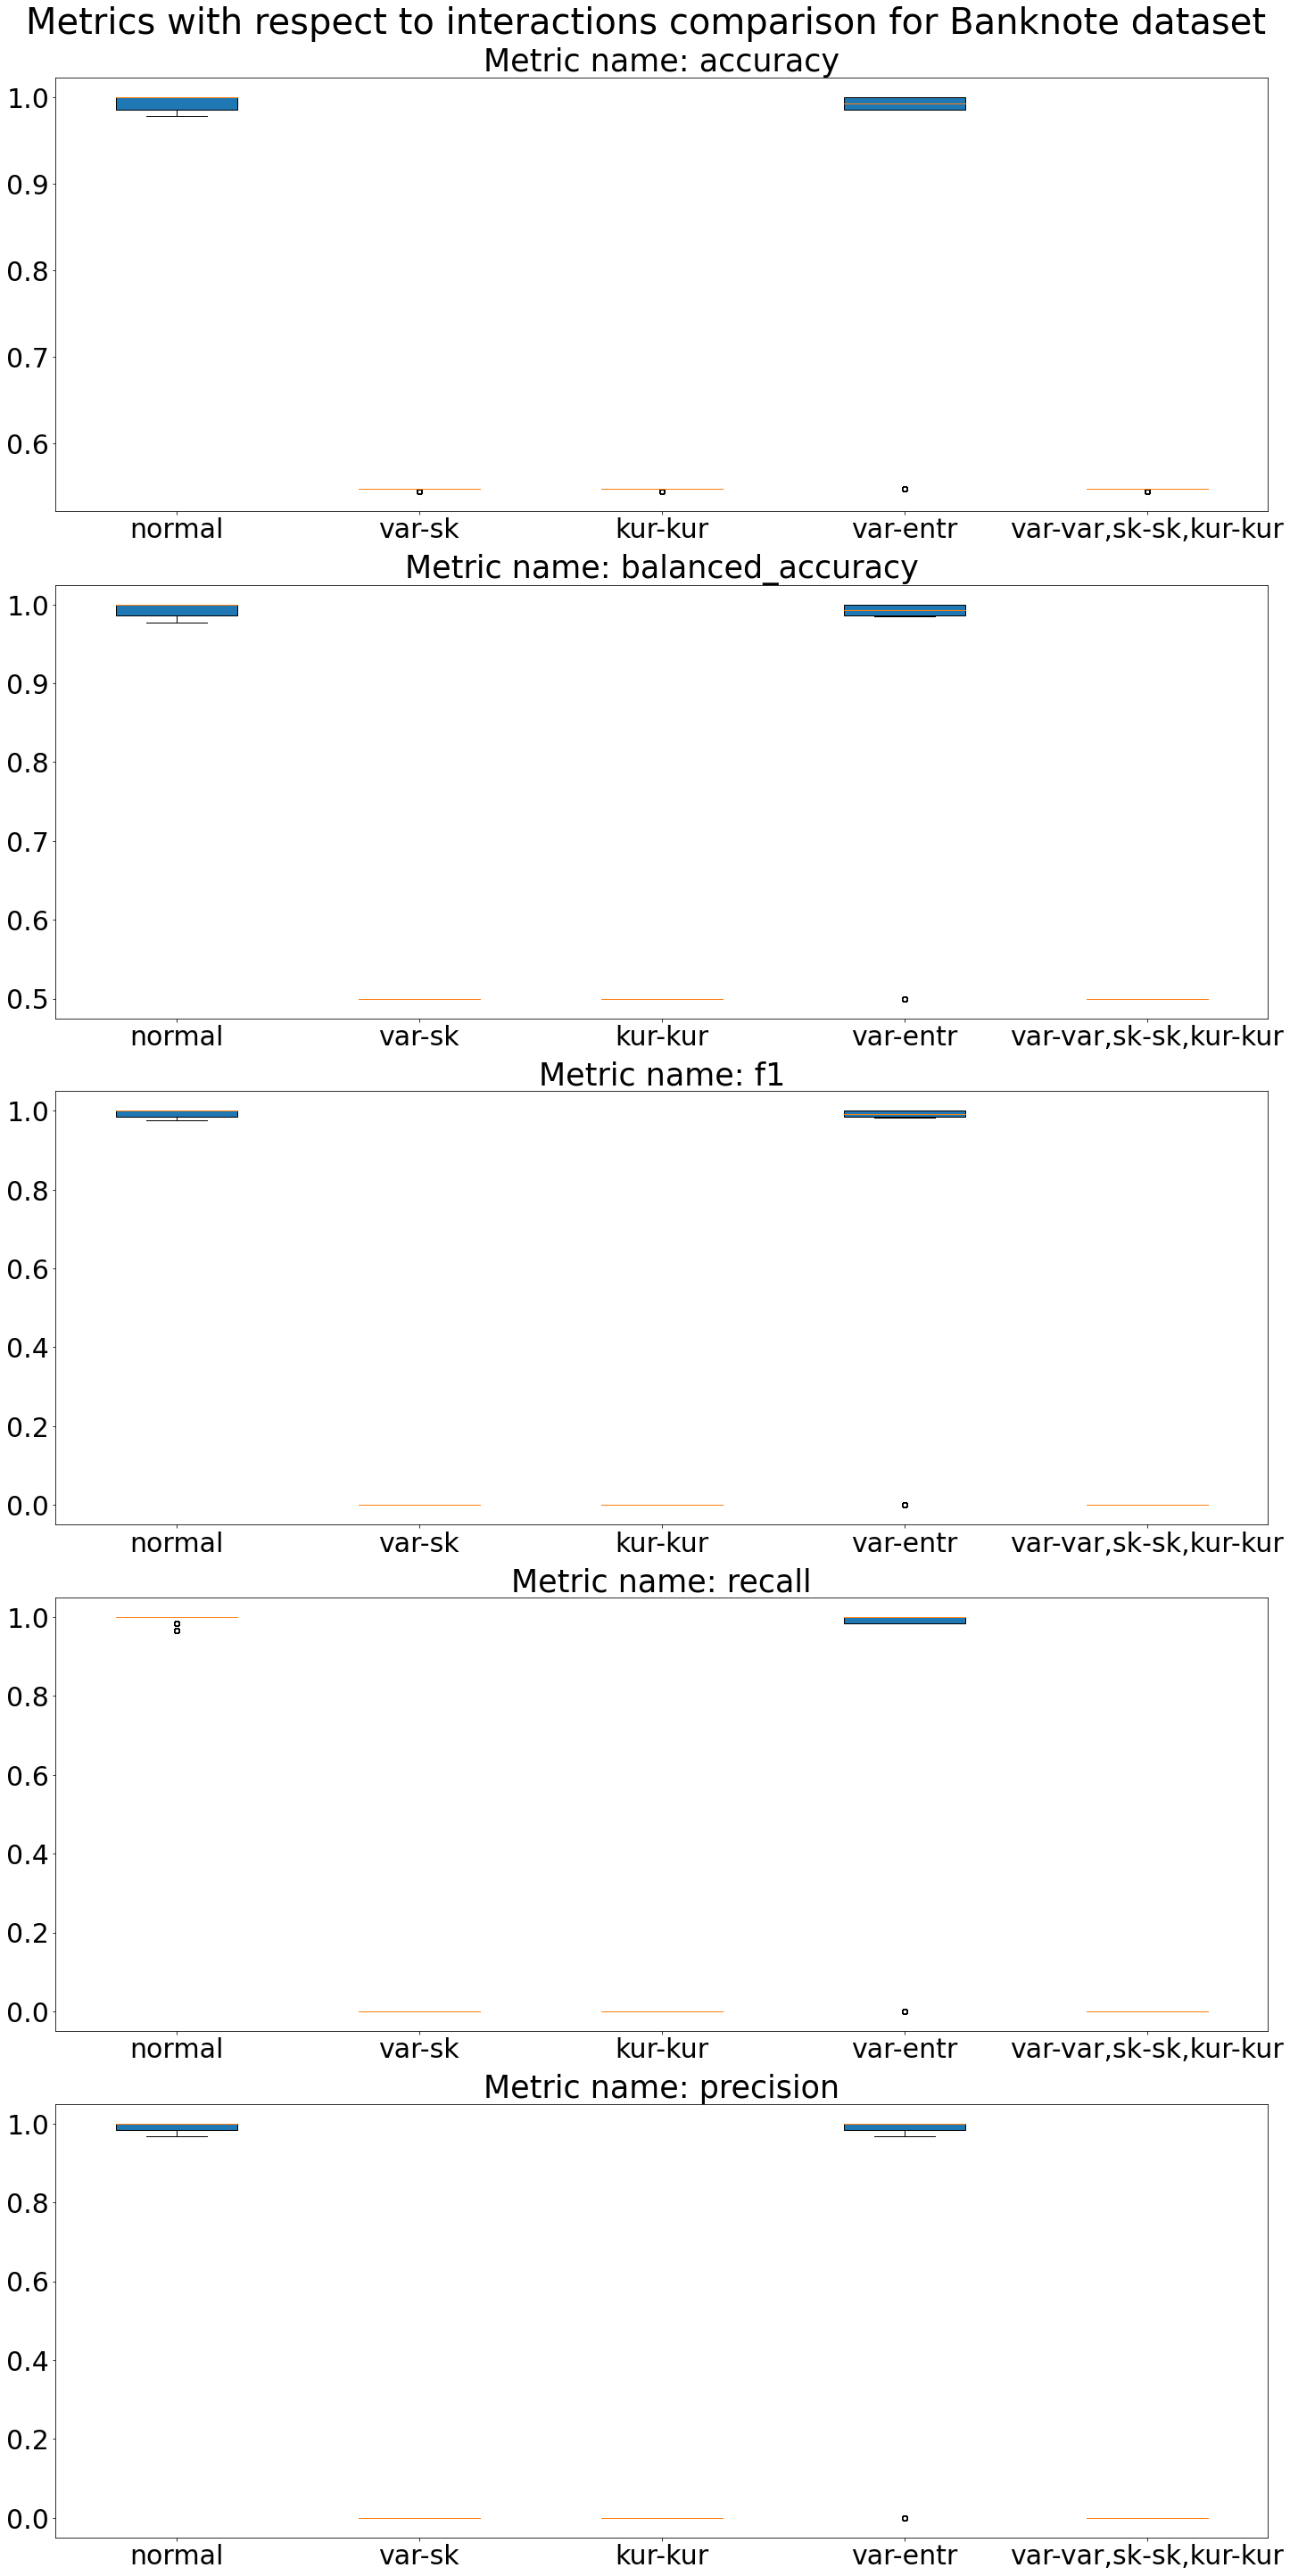

In [54]:
fig, ax = plt.subplots(5,1,figsize=(20,40), layout="constrained")
fig.suptitle("Metrics with respect to interactions comparison for Banknote dataset", fontsize=40)
matplotlib.rc('xtick', labelsize=30)
matplotlib.rc('ytick', labelsize=30)
for i, (dictionary, metric_name) in enumerate(zip(inter_dict_bank, scoring)):
    labels, data = dictionary.keys(), dictionary.values()
    ax[i].boxplot(data, patch_artist=True)
    ax[i].set_xticks(range(1, len(labels) + 1), labels)
    ax[i].set_title(f"Metric name: {metric_name}", fontsize=35)
plt.show()

What is interesting, adding interactions completely destabilized model in case of the **Banknote dataset**.      
Only the 0x3 interaction seemed to have worked (variance x entropy).

Let us see if not scaling the columns beforhand will improve the results:

In [55]:
inter_dict_bank =[{in_name:np.array([]) for in_name in interactions_names_bank} for i in range(len(scoring))]

In [56]:
for i in range(N):
    for interaction, in_name in zip(interactions_bank, interactions_names_bank):
        pipe = Pipeline([('model', IRLS(interactions=interaction))])
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=12)
        score = cross_validate(pipe, X_bank, y_bank, scoring=scoring, cv=cv)
        for metric_name, metric_dict in zip(scoring, inter_dict_bank):
            metric_dict[in_name] = np.concatenate([metric_dict[in_name], score['test_' + metric_name]])

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classificatio

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\pythonProject1\IRLS.py:27: RuntimeWarning: divide by zero encountered in log
  L = y * np.log(p) + (1 - y) * np.log(1 - p)
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisi

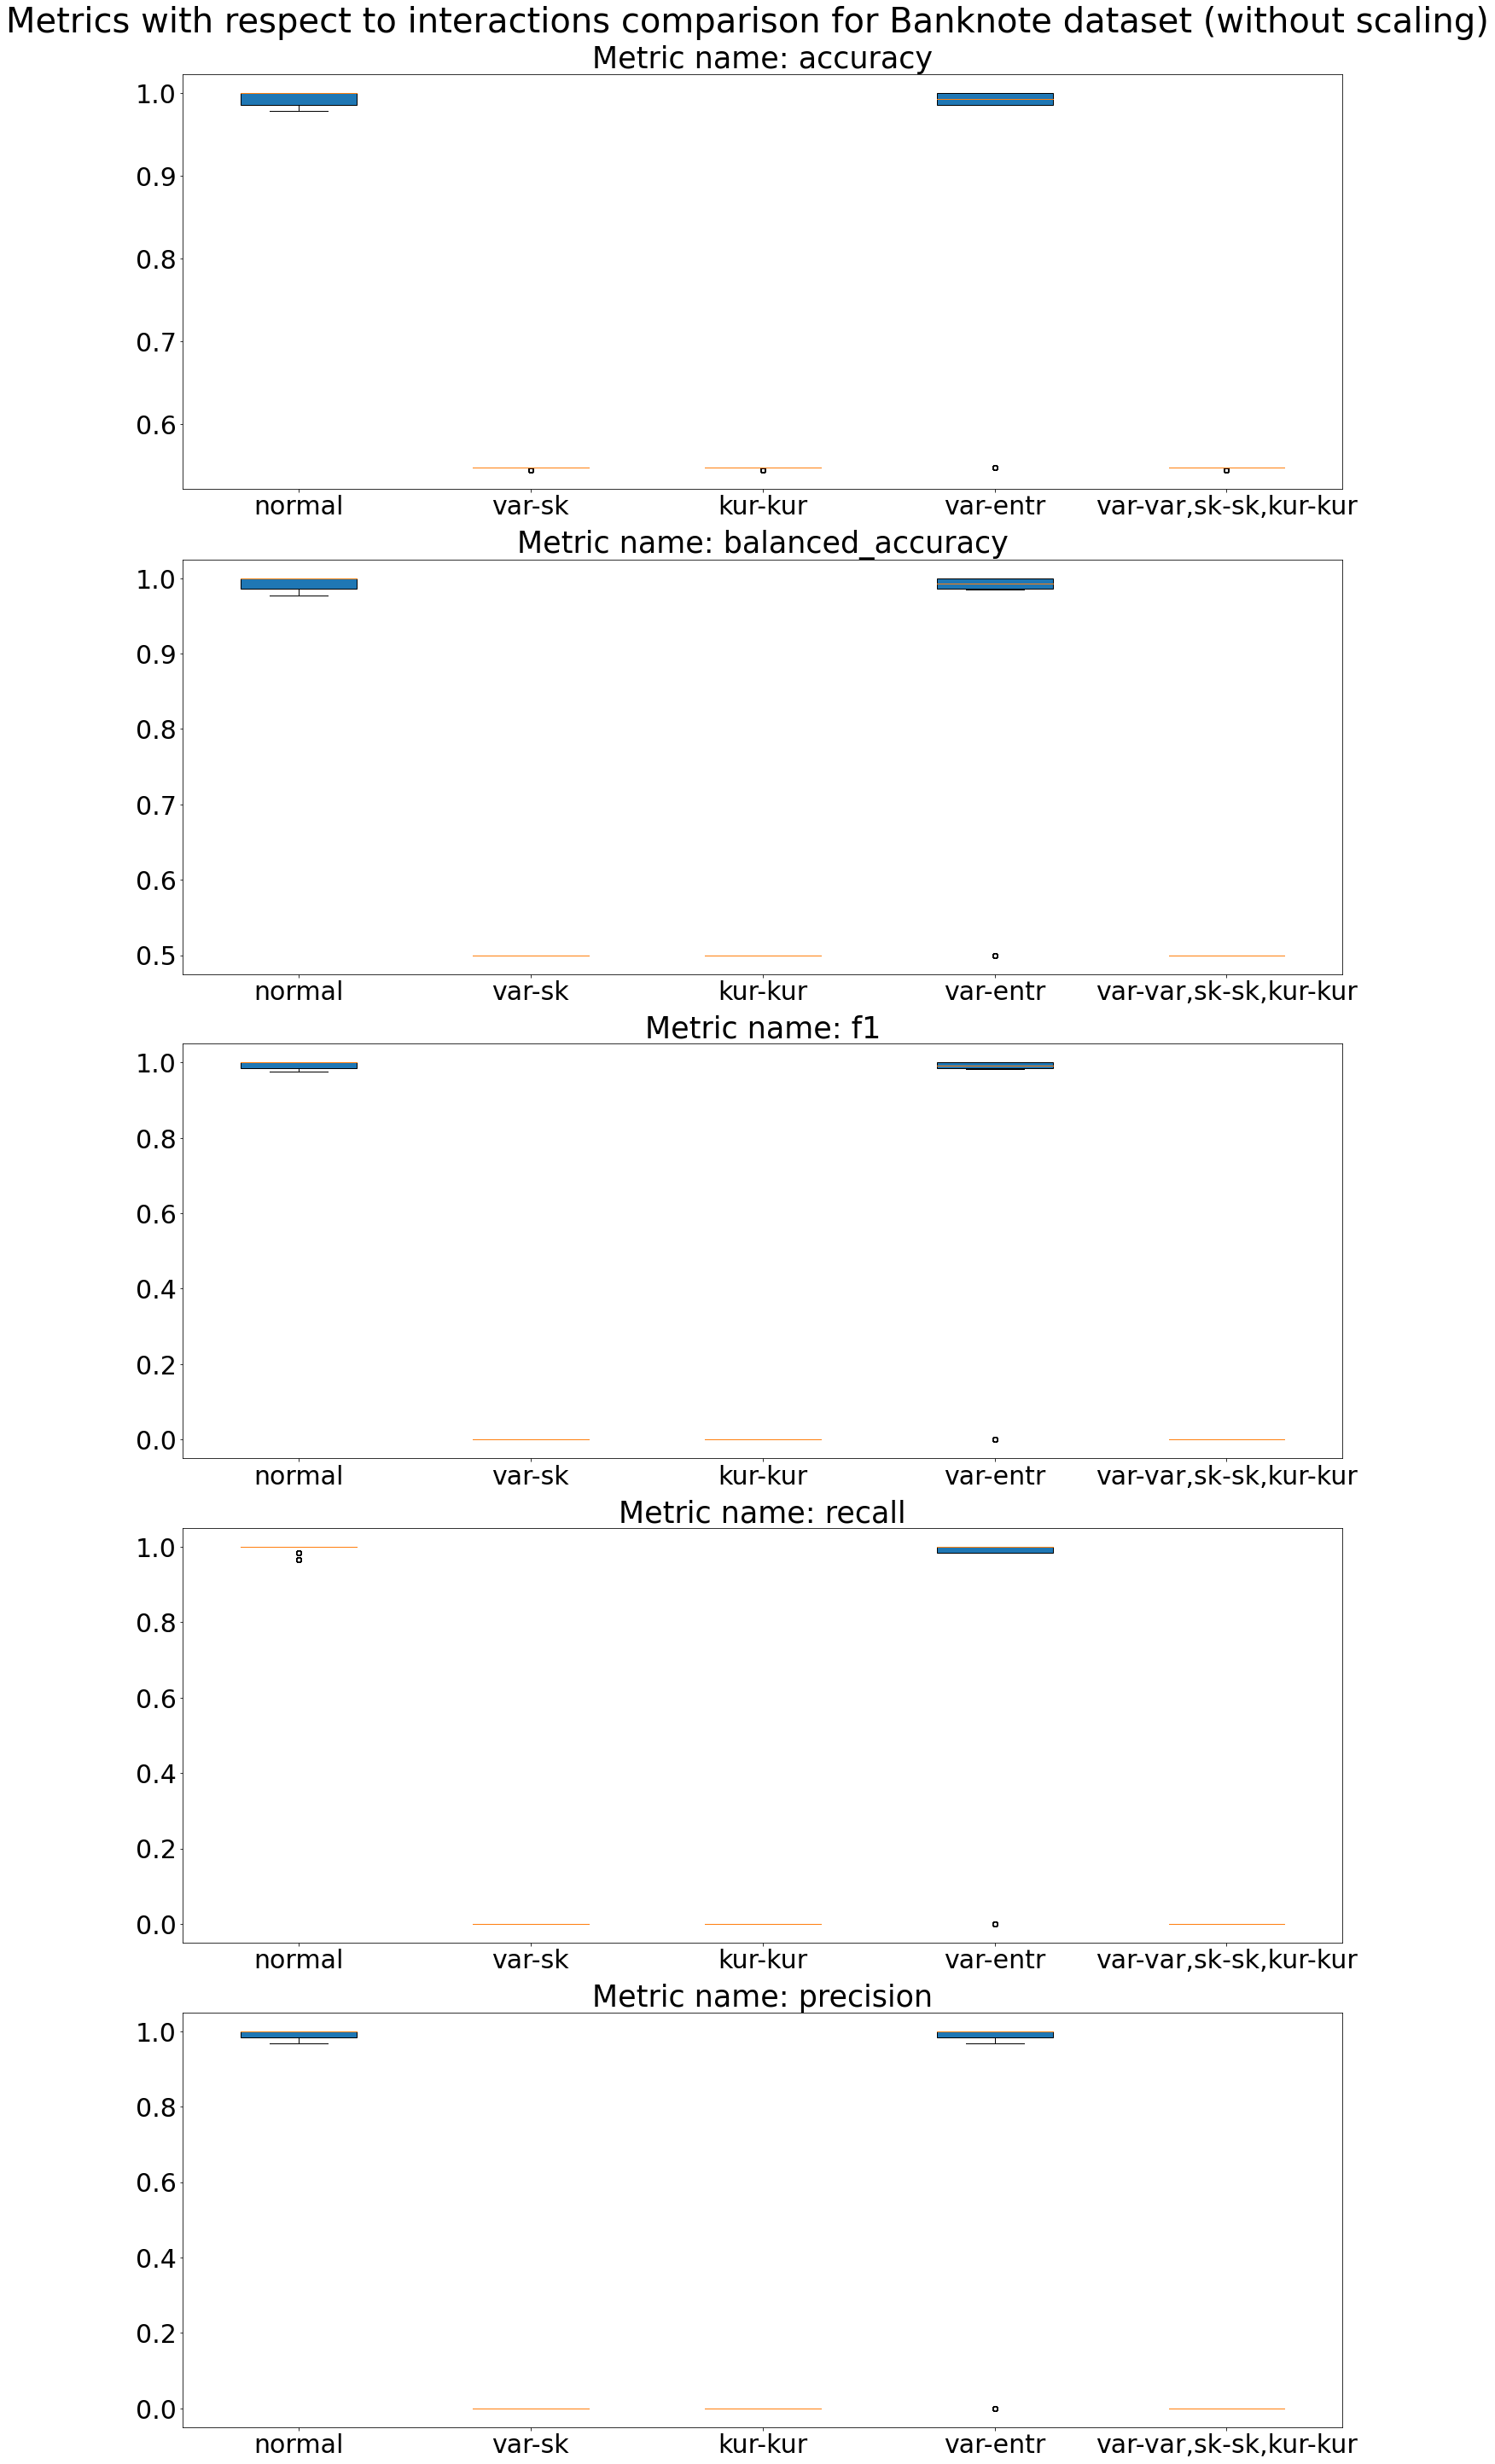

In [57]:
fig, ax = plt.subplots(5,1,figsize=(20,40), layout="constrained")
fig.suptitle("Metrics with respect to interactions comparison for Banknote dataset (without scaling)", fontsize=40)
matplotlib.rc('xtick', labelsize=30)
matplotlib.rc('ytick', labelsize=30)
for i, (dict, metric_name) in enumerate(zip(inter_dict_bank, scoring)):
    labels, data = dict.keys(), dict.values()
    ax[i].boxplot(data, patch_artist=True)
    ax[i].set_xticks(range(1, len(labels) + 1), labels)
    ax[i].set_title(f"Metric name: {metric_name}", fontsize=35)
plt.show()

As we can see, not scaling variables did not improve the results.